In [1]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute
import gmsh
import pygmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

INFO:capytaine.io.meshio:Stored 772 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_0"), lid_mesh=None, dofs={}, center_of_mass=[0. 0. 0.], name="mesh_from_meshio_0").
INFO:capytaine.bodies.bodies:Clipping mesh_from_meshio_0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])


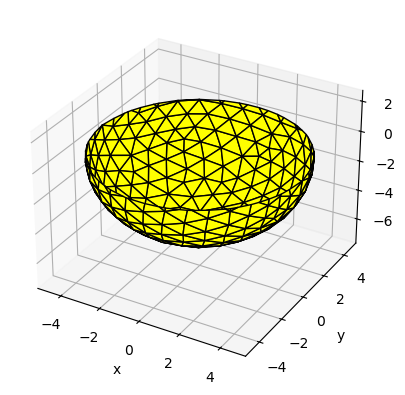

In [2]:
radius = 5
mesh_size_factor = 1

# mesh 1st flap
with pygmsh.geo.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    sphere = geom.add_ball([0, 0, 0], radius,mesh_size=mesh_size_factor)
    sphere_mesh = geom.generate_mesh()

sphere_fb = cpy.FloatingBody(mesh=sphere_mesh, center_of_mass=(0,0,0))
sphere_fb.keep_immersed_part()
sphere_fb.show_matplotlib()


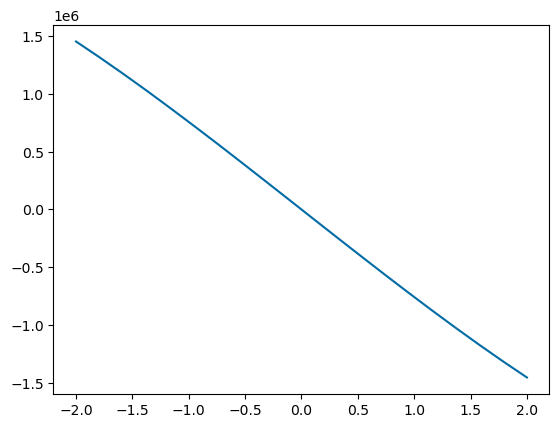

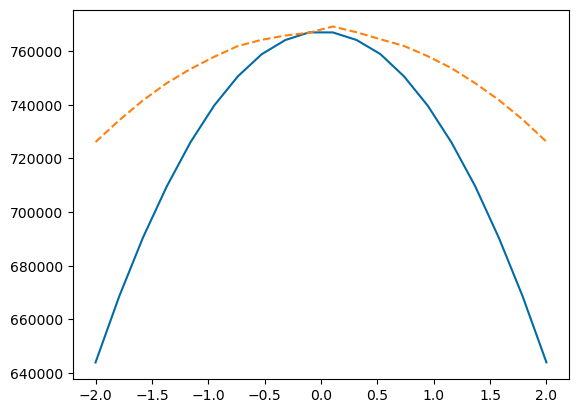

In [ ]:
# analytically calculate hydrostatic force
logging.getLogger().setLevel(logging.ERROR)

mesh_size_factor = .7
with pygmsh.geo.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
    sphere = geom.add_ball([0, 0, 0], radius,mesh_size=mesh_size_factor)
    sphere_mesh = geom.generate_mesh()

sphere_fb = cpy.FloatingBody(mesh=sphere_mesh, center_of_mass=(0,0,0))
sphere_fb.keep_immersed_part()
sphere_fb.rotation_center = sphere_fb.center_of_mass
sphere_fb.add_translation_dof(name='Heave')

hs = sphere_fb.compute_hydrostatics()
V = hs['disp_volume']
rho = 1000
g = 9.81
mass = rho*V

disp_vec = np.linspace(-2,2,20)
nl_hs_vec = []
hs_force_vec = []
hs_analytical_vec = []

for disp in disp_vec:
    # mesh 
    with pygmsh.geo.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        sphere = geom.add_ball([0, 0, disp], radius,mesh_size=mesh_size_factor)
        sphere_mesh = geom.generate_mesh()
    
    sphere_fb = cpy.FloatingBody(mesh=sphere_mesh, center_of_mass=(0,0,0))
    
    sphere_fb.keep_immersed_part()
    sphere_fb.add_translation_dof(name='Heave')
    sphere_fb.rotation_center = sphere_fb.center_of_mass
    hs = sphere_fb.compute_hydrostatics()

    nl_hs_vec.append(hs['hydrostatic_stiffness'])
    hs_force = rho*hs['disp_volume']*g - mass*g
    hs_force_vec.append(hs_force)
    hs_analytical_vec.append(-hs_force/disp)

plt.figure()
plt.plot(disp_vec, hs_force_vec)

plt.figure()
plt.plot(disp_vec,np.squeeze(nl_hs_vec))
plt.plot(disp_vec,hs_analytical_vec,'--')

In [31]:
# calculate stiffness using capytaine's method:
motion = np.empty((sphere_fb.mesh.nb_faces, 3))
motion[:, :] = np.array((0, 0, 1)) # motion in heave direction

# Newman (1994) formula for flexible DOFs
influenced_dof = np.array(motion)
radiating_dof = np.array(motion)
influenced_dof_div_array = np.array(0)

radiating_dof_normal = sphere_fb.mesh.faces_normals*radiating_dof
z_influenced_dof_div = influenced_dof[:,2]
normal_z = -radiating_dof_normal * z_influenced_dof_div[:,np.newaxis]
norm_hs_stiff = np.sum(normal_z * sphere_fb.mesh.faces_areas[:,np.newaxis])

hs_stiff = 1000 * 9.81 * norm_hs_stiff
print('heave')
print(hs_stiff)

sphere_fb.add_translation_dof(name='Heave')
sphere_fb.rotation_center = sphere_fb.center_of_mass

hs = sphere_fb.compute_hydrostatic_stiffness()
print(hs.values)

## PITCH
sphere_fb = cpy.FloatingBody(mesh=sphere_mesh, center_of_mass=(0,0,0))
sphere_fb.keep_immersed_part()
sphere_fb.rotation_center = sphere_fb.center_of_mass
sphere_fb.add_rotation_dof(name='Pitch')

# calculate stiffness using capytaine's method:
motion = np.cross(sphere_fb.rotation_center - sphere_fb.mesh.faces_centers, (0,1,0))

# Newman (1994) formula for flexible DOFs
influenced_dof = np.array(motion)
radiating_dof = np.array(motion)
influenced_dof_div_array = np.array(0)

radiating_dof_normal = sphere_fb.mesh.faces_normals*radiating_dof
z_influenced_dof_div = influenced_dof[:,2] 
normal_z = -radiating_dof_normal * z_influenced_dof_div[:,np.newaxis]
norm_hs_stiff = np.sum(normal_z * sphere_fb.mesh.faces_areas[:,np.newaxis])

hs_stiff = 1000 * 9.81 * norm_hs_stiff
print('pitch')
print(hs_stiff)

hs = sphere_fb.compute_hydrostatic_stiffness()
print(hs.values)

mass = sphere_fb.disp_mass()
# check pitch 
norm_hs_stiff = (-sphere_fb.waterplane_integral((sphere_fb.mesh.faces_centers[:,0] - sphere_fb.rotation_center[0])**2)
                        + sphere_fb.volume*(sphere_fb.center_of_buoyancy[2] - sphere_fb.rotation_center[2]) - mass/1000*(sphere_fb.center_of_mass[2] - sphere_fb.rotation_center[2]))
hs_stiff = 1000 * 9.81 * norm_hs_stiff
print(hs_stiff)

## What if I use the a different name for the pitch dof but same rotation center??
sphere_fb = cpy.FloatingBody(mesh=sphere_mesh, center_of_mass=(0,0,0))
sphere_fb.keep_immersed_part()
sphere_fb.rotation_center = sphere_fb.center_of_mass
axis = cpy.Axis(vector=(0, 1, 0), point=sphere_fb.center_of_mass)
sphere_fb.add_rotation_dof(name='Pitch2',axis=axis)
hs = sphere_fb.compute_hydrostatic_stiffness()
print(hs.values)

INFO:capytaine.io.meshio:Stored 772 triangle faces as quadrilaterals


INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_92"), lid_mesh=None, dofs={}, center_of_mass=[0. 0. 0.], name="mesh_from_meshio_92").
INFO:capytaine.bodies.bodies:Clipping mesh_from_meshio_92 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="mesh_from_meshio_92").rotation_center = [0. 0. 0.]


heave
755631.0756006275
[[0.00000000e+00 0.00000000e+00]
 [2.34162689e-11 7.55631076e+05]]
pitch
-45296.86539875836
[[-30633.19312203]]
-30633.193122030578


INFO:capytaine.io.meshio:Stored 772 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_98"), lid_mesh=None, dofs={}, center_of_mass=[0. 0. 0.], name="mesh_from_meshio_98").
INFO:capytaine.bodies.bodies:Clipping mesh_from_meshio_98 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])


[[-45296.86539876]]
